In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

In [29]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

print(f"Train Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")


Train Data Shape: (12654, 25)
Test Data Shape: (5852, 24)


In [30]:
missing_count = train_df['spend_category'].isnull().sum()

# 3. Check for missing values represented by empty strings (if the column is a string type)
if train_df['spend_category'].dtype == 'object':
    empty_string_count = (train_df['spend_category'] == '').sum()
else:
    empty_string_count = 0

total_missing = missing_count + empty_string_count
total_rows = len(train_df)


print(f"Total rows in train_df: {total_rows}")
print(f"Missing (NaN/None) count: {missing_count}")
print(f"Missing (Empty string) count: {empty_string_count}")
print(f"Total missing values in 'spend_category': {total_missing}")


Total rows in train_df: 12654
Missing (NaN/None) count: 34
Missing (Empty string) count: 0
Total missing values in 'spend_category': 34


In [31]:
train_df.dropna(subset=['spend_category'], inplace=True)
missing_count_1 = train_df['spend_category'].isnull().sum()

print(f"Total rows in train_df: {len(train_df)}")
print(f"Missing (NaN/None) count: {missing_count_1}")

Total rows in train_df: 12620
Missing (NaN/None) count: 0


In [ ]:
train_df['source'] = 'train'
test_df['source'] = 'test'
target = train_df['spend_category'].astype(int) # Target assumed to be classification
train_df = train_df.drop('spend_category', axis=1)

# Concatenate for consistent preprocessing
combined_df = pd.concat([train_df, test_df], ignore_index=True)

combined_df = combined_df.drop('trip_id', axis=1) # Drop ID column

print(f"Combined Data Shape: {combined_df.shape}")

Combined Data Shape: (18472, 24)


In [33]:
# removing columns with many missing values

missing_data = combined_df.isnull().sum()
total_rows = len(combined_df)
missing_percentage = (missing_data / total_rows) * 100
missing_summary = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

print(missing_summary.to_string())

has_special_requirements    63.945431
arrival_weather             27.003032
days_booked_before_trip     11.985708
travel_companions            5.797964
total_trip_days              3.004547
country                      1.911000
insurance_included           1.851451
food_included                1.347986
intl_transport_included      1.098961
accomodation_included        1.098961
main_activity                1.044825
is_first_visit               0.741663
age_group                    0.043309
num_males                    0.032482
num_females                  0.010827


In [34]:
combined_df = combined_df.drop('has_special_requirements', axis = 1)
print(combined_df.shape)

(18472, 23)


In [40]:
numerical_cols = combined_df.select_dtypes(include=np.number).columns.tolist()
# Numerical Imputation (Median)
for col in numerical_cols:
    if combined_df[col].isnull().any():
        median_val = combined_df[col].median()
        combined_df[col].fillna(median_val, inplace=True)

In [41]:
categorical_cols = combined_df.select_dtypes(include=['object']).columns.tolist()
# Remove 'source' from categorical_cols
categorical_cols.remove('source')
for col in categorical_cols:
    if combined_df[col].isnull().any():
        # Fill with a specific string for clarity, or use mode for high frequency
        combined_df[col].fillna('Missing', inplace=True)

In [42]:
missing_data = combined_df.isnull().sum()
total_rows = len(combined_df)
missing_percentage = (missing_data / total_rows) * 100
missing_summary = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

print(missing_summary.to_string())

Series([], )


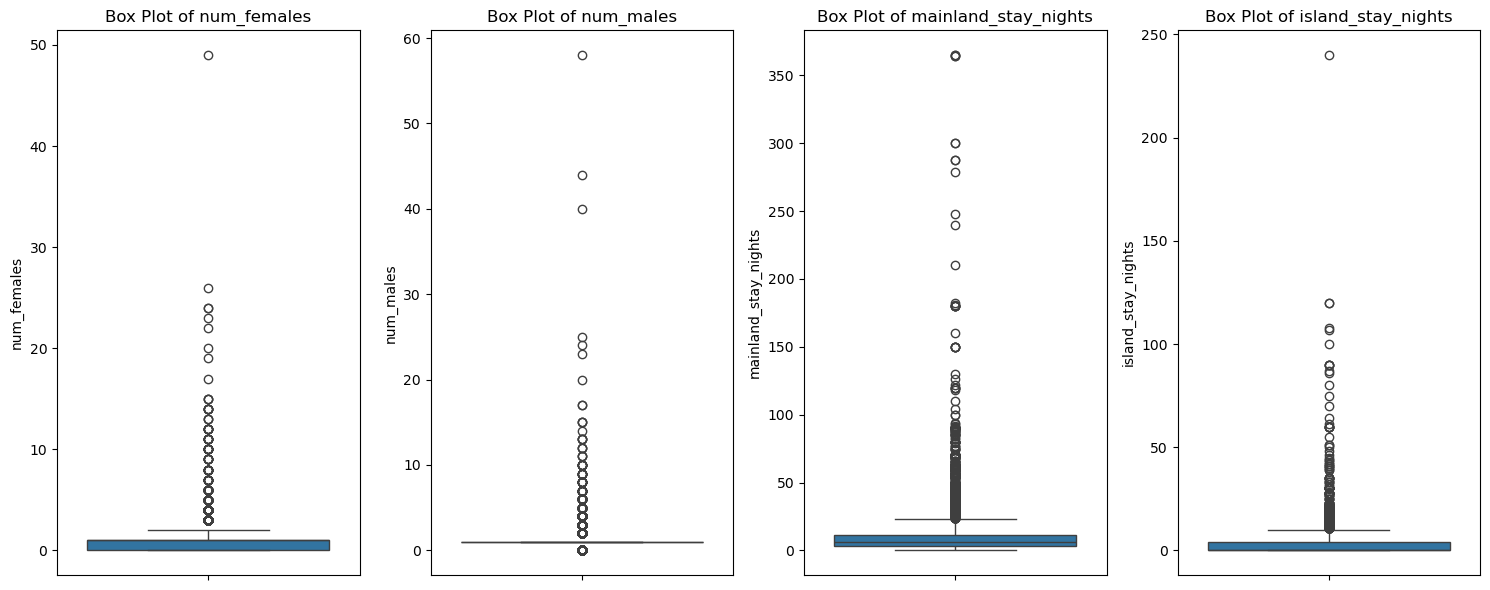

In [45]:

import matplotlib.pyplot as plt
import seaborn as sns

outlier_cols = ['num_females', 'num_males', 'mainland_stay_nights', 'island_stay_nights']

# Create box plots for visualization
plt.figure(figsize=(15, 6))
for i, col in enumerate(outlier_cols):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=combined_df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show() #

Interquartile Range (IQR) method
Any data point that falls outside the range below will be capped or removed:

$$[Q1 - 1.5 \times IQR, \quad Q3 + 1.5 \times IQR]$$

In [47]:
def cap_outliers_iqr(df, column):
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the upper bound for capping
    upper_bound = Q3 + 1.5 * IQR

    # Define the lower bound (often 0 for count/time data)
    lower_bound = Q1 - 1.5 * IQR
    if lower_bound < 0:
        lower_bound = 0

    # Cap the values
    # If a value > upper_bound, set it to upper_bound. Otherwise, keep original.
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else x)
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else x)
    return df

# Apply the capping function to the relevant columns in the combined DataFrame
numerical_cols_to_cap = ['num_females', 'num_males', 'mainland_stay_nights', 'island_stay_nights']

for col in numerical_cols_to_cap:
    combined_df = cap_outliers_iqr(combined_df, col)
    

# Note: You should re-run your full data preparation script 
# with this updated capping logic incorporated in step 2.

In [48]:
# Total number of travelers
combined_df['total_travelers'] = combined_df['num_females'] + combined_df['num_males']

# Total stay nights
combined_df['total_stay_nights'] = combined_df['mainland_stay_nights'] + combined_df['island_stay_nights']

# Trip Type feature
def get_trip_type(row):
    is_mainland = row['mainland_stay_nights'] > 0
    is_island = row['island_stay_nights'] > 0
    if is_mainland and is_island:
        return 'Both'
    elif is_mainland:
        return 'Mainland Only'
    elif is_island:
        return 'Island Only'
    else:
        return 'No Stay'
combined_df['trip_type'] = combined_df.apply(get_trip_type, axis=1)
categorical_cols.append('trip_type')

ORDINAL MAPPING

Mapping range columns to mid point of the range

In [ ]:
def map_range_to_midpoint(range_str):
    if pd.isna(range_str) or range_str in ['Missing', 'none', '30+','90+']:
        # Assign a default large value for '30+' and '90+' or 0 for 'none'
        if '30+' in str(range_str): return 45 # Midpoint of 30-60
        if '90+' in str(range_str): return 100 # Default large value
        if 'none' in str(range_str): return 0
        return 0 # Default for 'Missing'
    try:
        if '-' in range_str:
            start, end = map(float, re.findall(r'\d+', range_str))
            return (start + end) / 2
        else: # Handle single number values if they exist
            return float(range_str)
    except:
        return 0

# Mapping days_booked_before_trip
combined_df['days_booked_midpoint'] = combined_df['days_booked_before_trip'].apply(map_range_to_midpoint)

# Mapping total_trip_days
combined_df['total_trip_days_midpoint'] = combined_df['total_trip_days'].apply(map_range_to_midpoint)

# Mapping age_group (a simpler Ordinal feature)
age_mapping = {'<18': 10, '18-24': 21, '25-44': 35, '45-64': 55, '65+': 70, 'Missing': 0}
combined_df['age_group_ordinal'] = combined_df['age_group'].map(age_mapping).fillna(0)


# Drop original ordinal columns
combined_df = combined_df.drop(['days_booked_before_trip', 'total_trip_days', 'age_group'], axis=1)